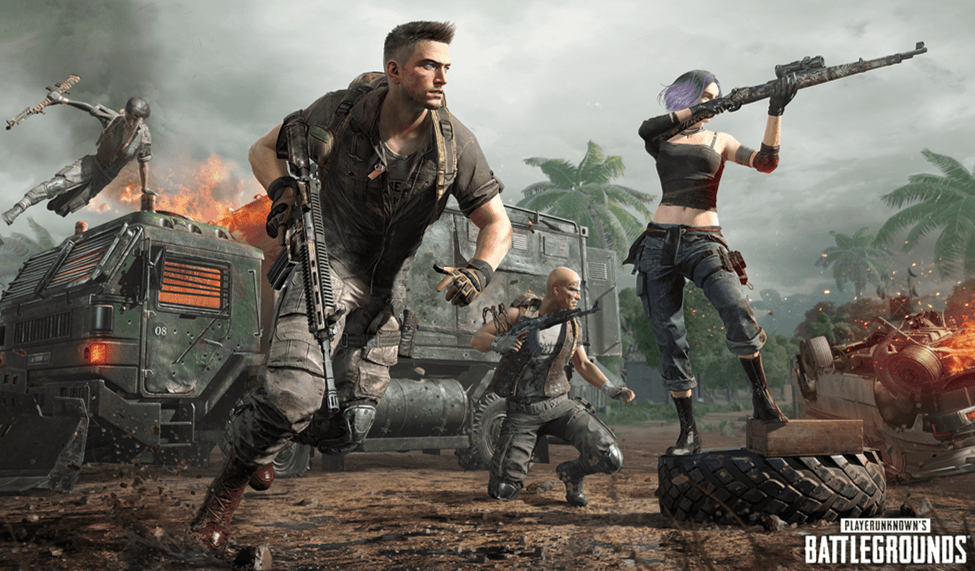

# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Reading data

In [4]:
df = pd.read_csv("pubg.csv")

In [5]:
df.head()

Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...        0   
1        91.47      0              0      0         57  ...        0   
2        68.00      0              0      0         47  ...        0   
3        32.90      0              0      0         75  ...        0   
4       100.00      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000          0          0.00          0               0   
1        0.0045          0         11.04          0               0   
2        0.0000          0          0.00          0               0   
3        0.0000          0          0.00          0               0   
4        0.0000          0          0.00          0               0   

   walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0        244.80                1       1466        0.4444  
1       1434.00                5          0        0.6400  
2        161.80                2          0        0.7755  
3        202.70                3          0        0.1667  
4         49.75                2          0        0.1875  

[5 rows x 29 columns]

In [6]:
df.shape

(4446966, 29)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

Data Description:

DBNOs – Number of enemy players knocked.

assists – Number of enemy players this player damaged that were killed by teammates.

boosts – Number of boost items used.

damageDealt – Total damage dealt. Note: Self-inflicted damage is subtracted.

headshotKills – Number of enemy players killed with headshots.

heals – Number of healing items used.

Id – Player’s ID.

killPlace – Ranking in match of number of enemy players killed.

killPoints – Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter. If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as "None.")

killStreaks – Max number of enemy players killed in a short amount of time.

kills – Number of enemy players killed.

longestKill – Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration – Duration of match in seconds.

matchId – ID to identify match. There are no matches that are in both the training and testing set.

matchType – String identifying the game mode the data comes from. The standard modes are "solo", "duo", "squad", "solo-fpp", "duo-fpp", and "squad-fpp"; other modes are from events or custom matches.

rankPoints – Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of "None".

revives – Number of times this player revived teammates.

rideDistance – Total distance traveled in vehicles measured in meters.

roadKills – Number of kills while in a vehicle.

swimDistance – Total distance traveled by swimming measured in meters.

teamKills – Number of times this player killed a teammate.

vehicleDestroys – Number of vehicles destroyed.

walkDistance – Total distance traveled on foot measured in meters.

weaponsAcquired – Number of weapons picked up.

winPoints – Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters. If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as "None.")

groupId – ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups – Number of groups we have data for in the match.

maxPlace – Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc – The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.


# Data Wrangling and Cleaning

Dealing with Null Values

In [9]:
df['winPlacePerc'].isnull().sum()

1

In [10]:
df[df['winPlacePerc'].isnull()]

Id         groupId         matchId  assists  boosts  \
2744604  f70c74418bb064  12dfbede33f92b  224a123c53e008        0       0   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
2744604          0.0      0              0      0          1  ...        0   

         rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
2744604           0.0          0           0.0          0               0   

         walkDistance  weaponsAcquired  winPoints  winPlacePerc  
2744604           0.0                0          0           NaN  

[1 rows x 29 columns]

In [11]:
df.drop(2744604, inplace = True)

In [12]:
df['winPlacePerc'].isnull().sum()

0

Understanding Players distribution in a game

In [13]:
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

In [14]:
df

Id         groupId         matchId  assists  boosts  \
0        7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1        eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2        1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3        4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4        315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   
...                 ...             ...             ...      ...     ...   
4446961  afff7f652dbc10  d238e426f50de7  18492834ce5635        0       0   
4446962  f4197cf374e6c0  408cdb5c46b2ac  ee854b837376d9        0       1   
4446963  e1948b1295c88a  e26ac84bdf7cef  6d0cd12784f1ab        0       0   
4446964  cc032cdd73b7ac  c2223f35411394  c9c701d0ad758a        0       4   
4446965  0d8e7ed728b6fd  8c74f72fedf5ff  62a16aabcc095c        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  \
0               0.00      0              0      0         60  ...   
1              91.47      0              0      0         57  ...   
2              68.00      0              0      0         47  ...   
3              32.90      0              0      0         75  ...   
4             100.00      0              0      0         45  ...   
...              ...    ...            ...    ...        ...  ...   
4446961         0.00      0              0      0         74  ...   
4446962        44.15      0              0      0         69  ...   
4446963        59.06      0              0      0         66  ...   
4446964       180.40      1              1      2         11  ...   
4446965       268.00      0              0      1         18  ...   

         rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
0              0.0000          0         0.000          0                0   
1              0.0045          0        11.040          0                0   
2              0.0000          0         0.000          0                0   
3              0.0000          0         0.000          0                0   
4              0.0000          0         0.000          0                0   
...               ...        ...           ...        ...              ...   
4446961     1292.0000          0         0.000          0                0   
4446962        0.0000          0         0.000          0                0   
4446963        0.0000          0         2.184          0                0   
4446964        0.0000          0         0.000          0                0   
4446965     1369.0000          0         0.000          0                0   

        walkDistance  weaponsAcquired  winPoints  winPlacePerc  playersJoined  
0             244.80                1       1466        0.4444             96  
1            1434.00                5          0        0.6400             91  
2             161.80                2          0        0.7755             98  
3             202.70                3          0        0.1667             91  
4              49.75                2          0        0.1875             97  
...              ...              ...        ...           ...            ...  
4446961      1019.00                3       1507        0.1786             94  
4446962        81.70                6          0        0.2935             93  
4446963       788.70                4          0        0.4815             98  
4446964      2748.00                8          0        0.8000             94  
4446965      1244.00                5          0        0.5464             98  

[4446965 rows x 30 columns]

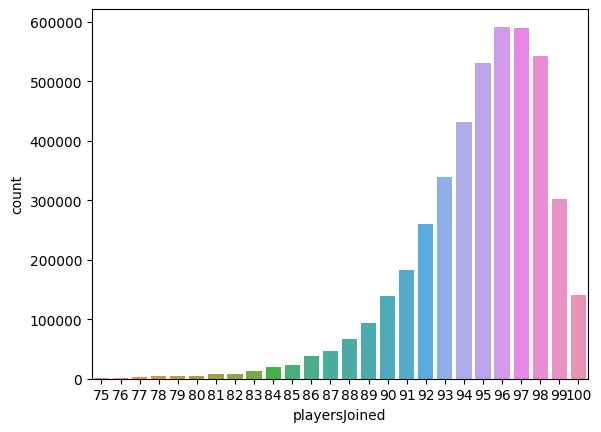

In [15]:
filtered_df = df[df['playersJoined'] >= 75]  
sns.countplot(x='playersJoined', data=filtered_df)  
plt.show()

# Analysing data

In [16]:
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']
df['killswithoutMoving'] = (df['kills']>0) & (df['totalDistance'] ==0)

In [17]:
df[df['killswithoutMoving'] == True].shape

(1535, 32)

Dropping modders and hackers

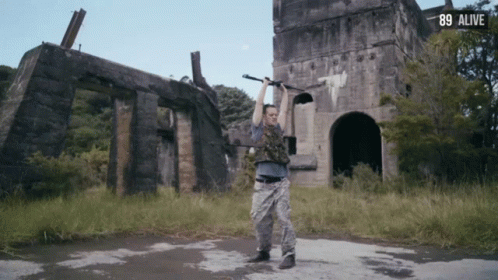

Dropping all the kills without moving

In [18]:
df.drop(df[df['killswithoutMoving'] == True].index, inplace = True)

Dropping road kills greater than 5

In [19]:
df[df['roadKills']>5].shape

(46, 32)

In [20]:
df.drop(df[df['roadKills']>5].index, inplace = True)

Analysing number of kills

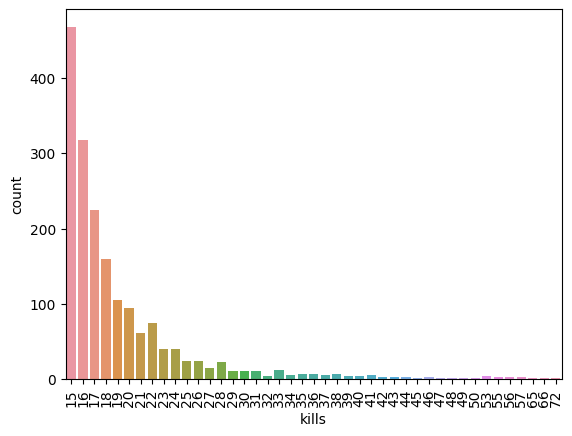

In [21]:
sns.countplot(x='kills', data=df[df['kills'] >= 15])
plt.xticks(rotation=90)
plt.show()

Dropping rows with kills greater than 25

In [22]:
df[df['kills']> 25].shape

(178, 32)

In [23]:
df.drop(df[df['kills']> 25].index, inplace = True)

Analysing Headshot rate

In [24]:
df['headshot_rate'] = df['headshotKills']/df['kills']


C:\Users\Vedant\AppData\Local\Temp\ipykernel_4624\2024965627.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['headshot_rate'], bins=20, kde=True, color='blue')
C:\Users\Vedant\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


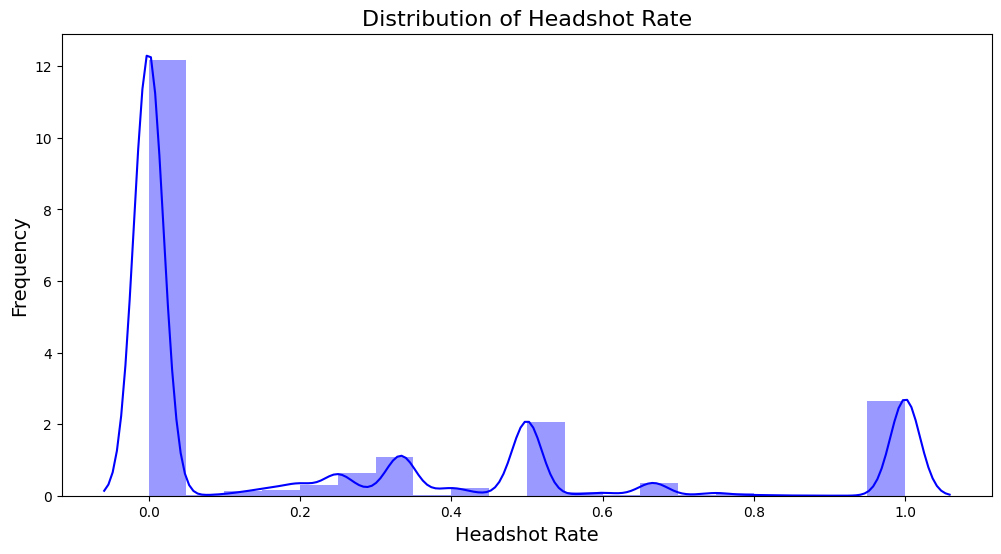

In [25]:
plt.figure(figsize=(12, 6))
sns.distplot(df['headshot_rate'], bins=20, kde=True, color='blue')
plt.xlabel('Headshot Rate', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Headshot Rate', fontsize=16)
plt.show()

Dropping rows with headshot rate >0.8 and with kills > 5


In [37]:
df[(df['headshot_rate'] > 0.8) & (df['kills']>5)].shape

(1077, 34)

In [38]:
df.drop(df[(df['headshot_rate'] > 0.8) & (df['kills']>5)].index, inplace = True)

Dropping very high distance kills

In [40]:
df[df['longestKill']>=600].shape

(695, 34)

In [41]:
df.drop(df[df['longestKill']>=600].index, inplace = True)

Dropping high weapon acquired rate

C:\Users\Vedant\AppData\Local\Temp\ipykernel_13876\1101139019.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['weaponsAcquired'], bins=100, kde=True, color='blue')
C:\Users\Vedant\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


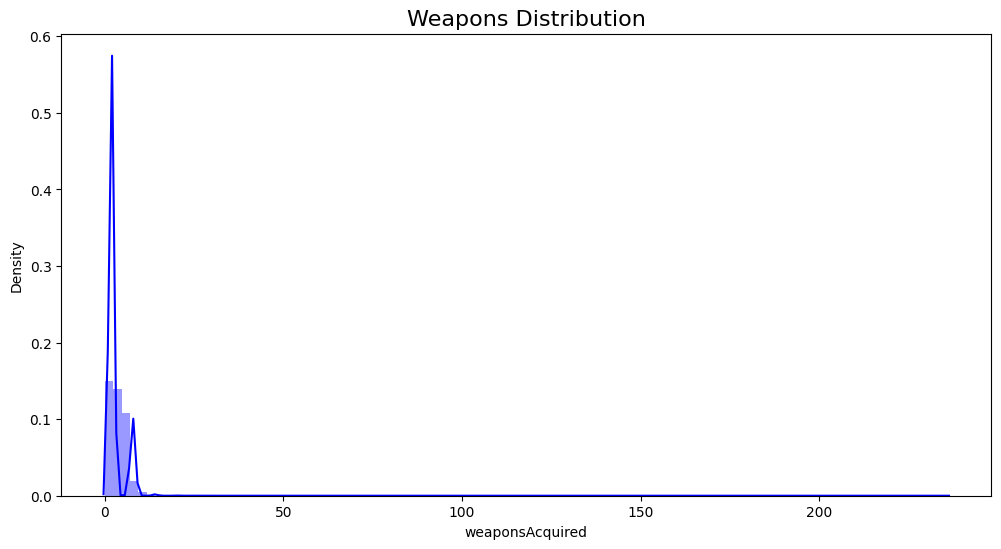

In [29]:
plt.figure(figsize=(12, 6))
sns.distplot(df['weaponsAcquired'], bins=100, kde=True, color='blue')
plt.title('Weapons Distribution', fontsize=16)
plt.show()

In [30]:
df[df['weaponsAcquired']>=15].shape

(6975, 33)

In [31]:
df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

In [32]:
df.isnull().sum()

Id                          0
groupId                     0
matchId                     0
assists                     0
boosts                      0
damageDealt                 0
DBNOs                       0
headshotKills               0
heals                       0
killPlace                   0
killPoints                  0
kills                       0
killStreaks                 0
longestKill                 0
matchDuration               0
matchType                   0
maxPlace                    0
numGroups                   0
rankPoints                  0
revives                     0
rideDistance                0
roadKills                   0
swimDistance                0
teamKills                   0
vehicleDestroys             0
walkDistance                0
weaponsAcquired             0
winPoints                   0
winPlacePerc                0
playersJoined               0
totalDistance               0
killswithoutMoving          0
headshot_rate         2528244
dtype: int

In [33]:
df['headshot_rate'] = df['headshot_rate'].fillna(0)

In [34]:
df.isnull().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
playersJoined         0
totalDistance         0
killswithoutMoving    0
headshot_rate         0
dtype: int64

Correlation between different features

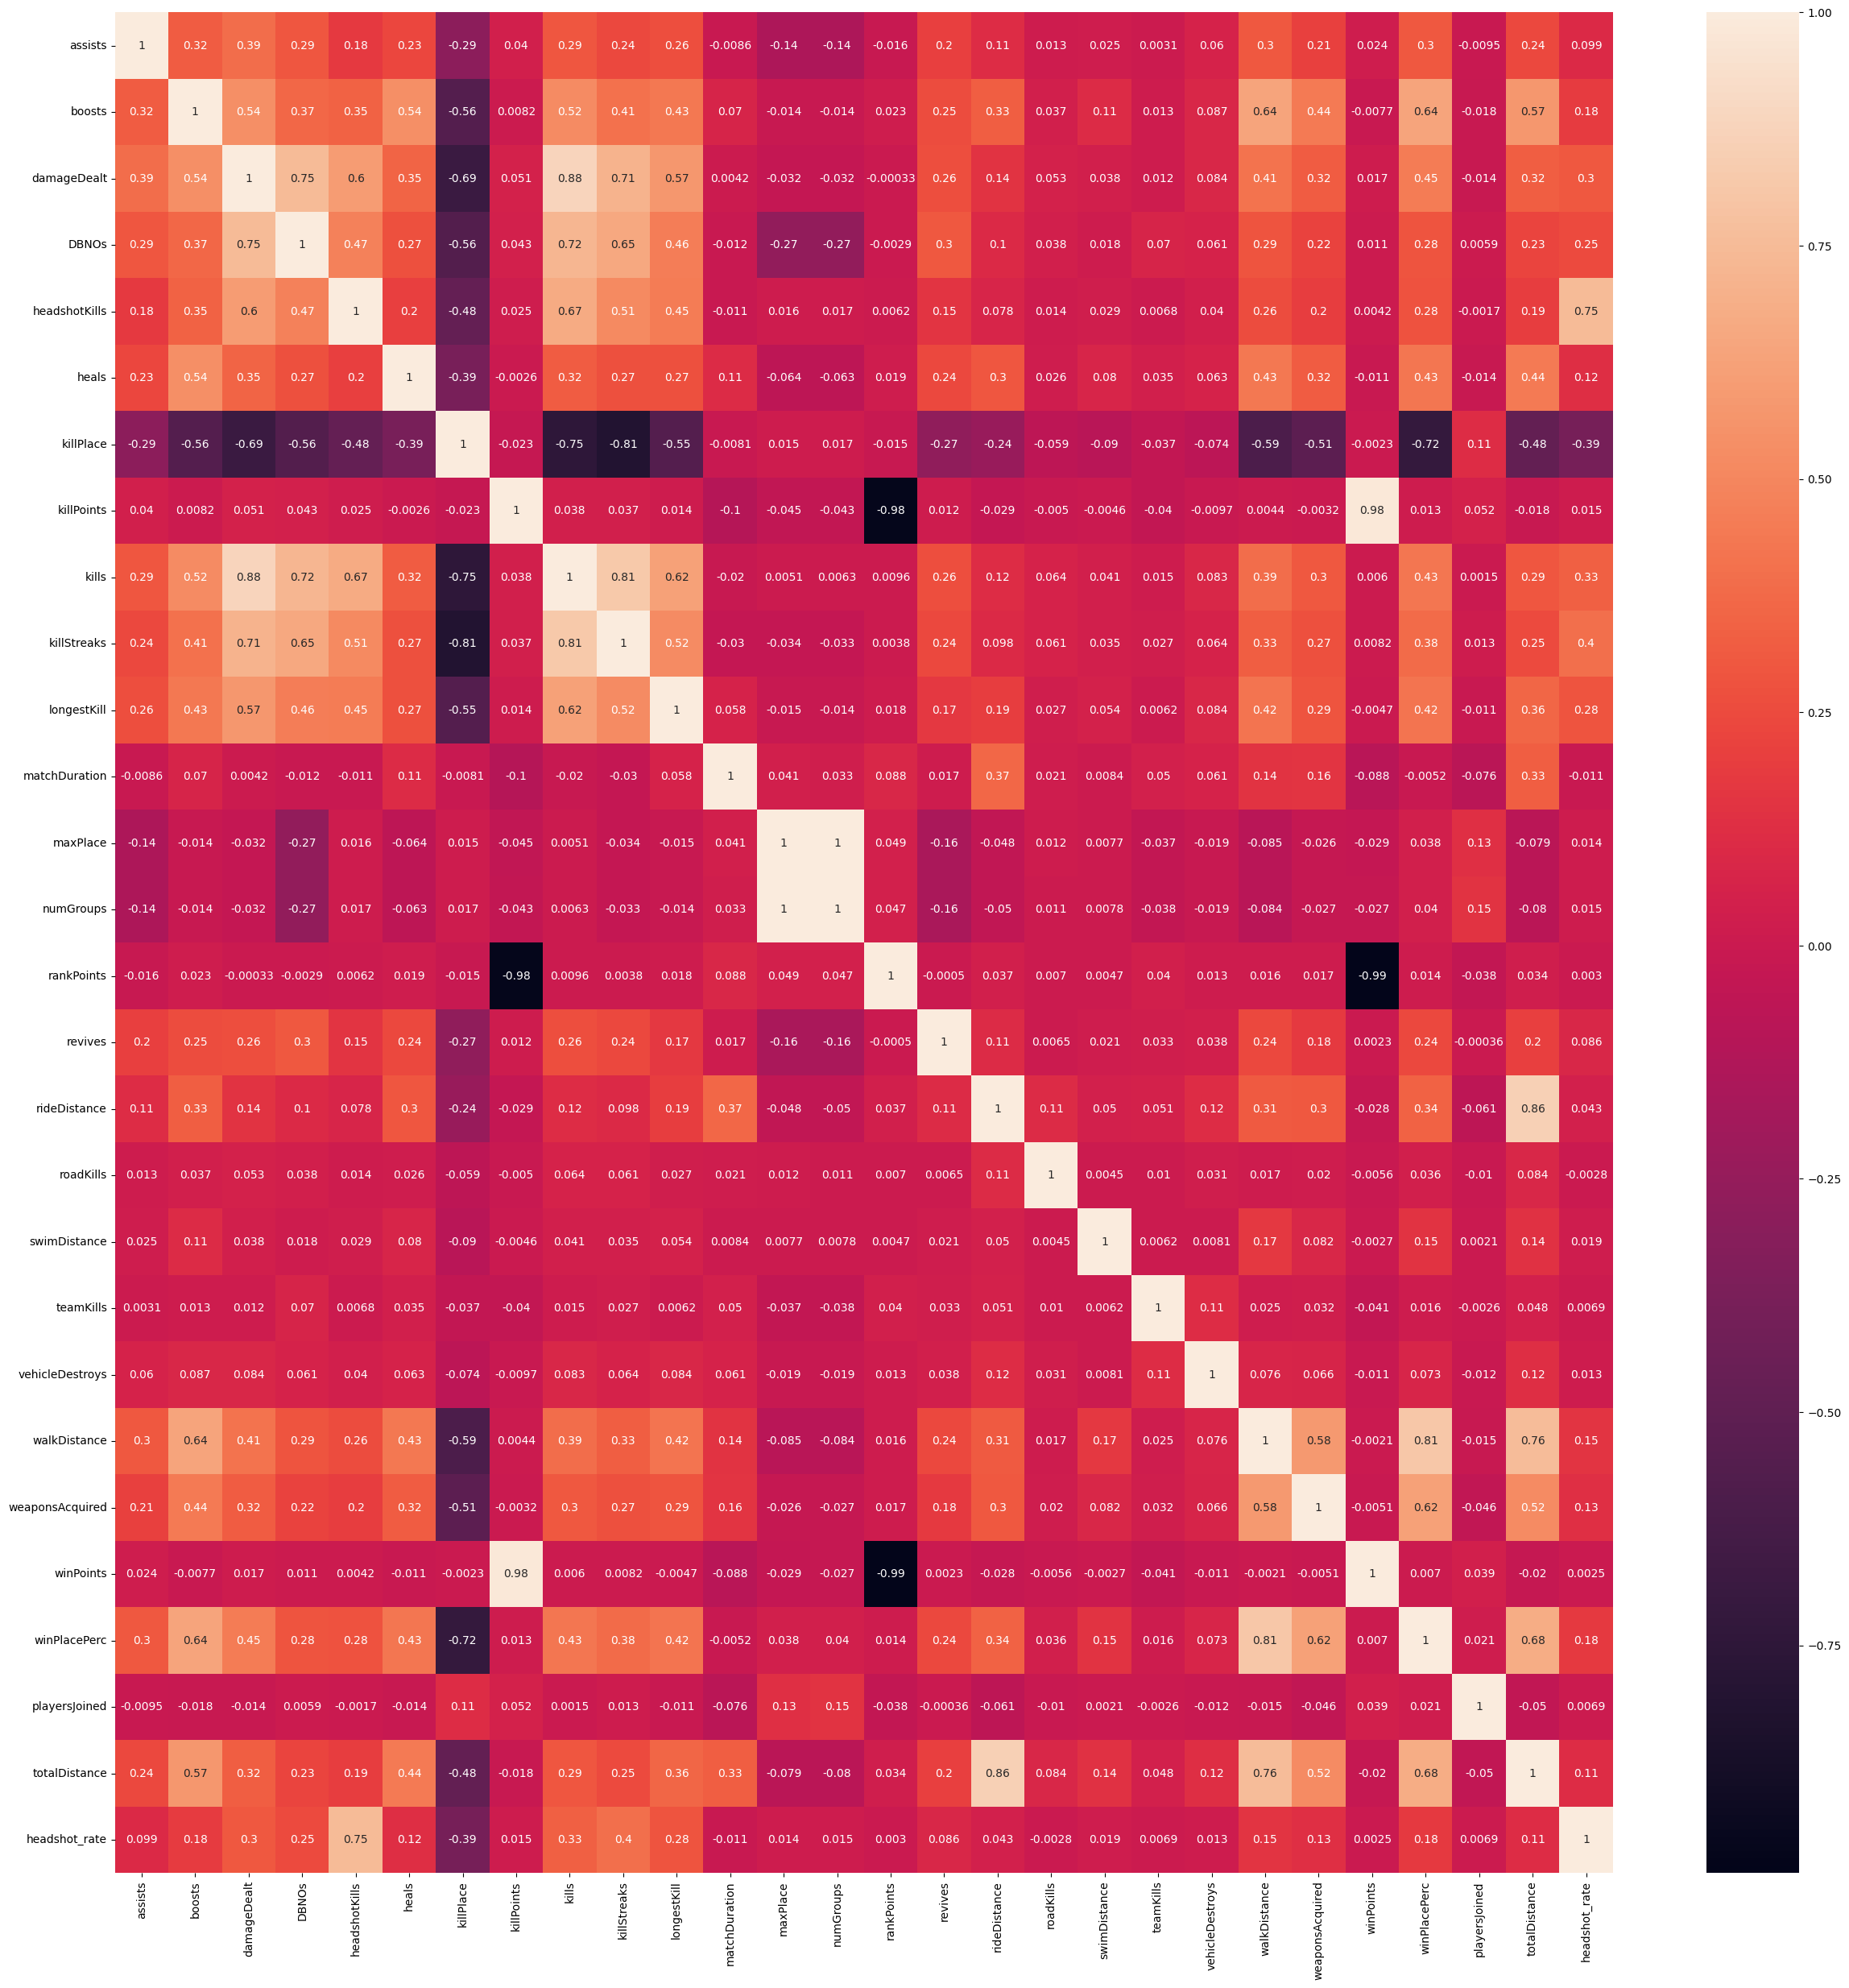

In [35]:
plt.figure(figsize = [30,30])
numeric_df = df.select_dtypes(include=[float, int])
sns.heatmap(numeric_df.corr(), annot=True) 
plt.show()

# Feature Engineering

Normalisation of features affected by the number of players joined

In [36]:
normalising_factor = (100 - df['playersJoined']/100) + 1

In [37]:
df['killsNorm'] = df['kills']*normalising_factor
df['damageDealtNorm'] = df['damageDealt']*normalising_factor
df['maxPlaceNorm'] = df['maxPlace']*normalising_factor
df['matchDurationNorm'] = df['matchDuration']*normalising_factor
df['healsnboosts'] = df['heals'] + df['boosts']

In [38]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'totalDistance', 'killswithoutMoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm', 'healsnboosts'],
      dtype='object')

In [39]:
data = df.drop(columns = ['Id','groupId','matchId','boosts','heals','kills','damageDealt','maxPlace','matchDuration','walkDistance','rideDistance','swimDistance'])

In [40]:
data.head()

assists  DBNOs  headshotKills  killPlace  killPoints  killStreaks  \
0        0      0              0         60        1241            0   
1        0      0              0         57           0            0   
2        1      0              0         47           0            0   
3        0      0              0         75           0            0   
4        0      0              0         45           0            1   

   longestKill  matchType  numGroups  rankPoints  ...  winPlacePerc  \
0         0.00  squad-fpp         26          -1  ...        0.4444   
1         0.00  squad-fpp         25        1484  ...        0.6400   
2         0.00        duo         47        1491  ...        0.7755   
3         0.00  squad-fpp         30        1408  ...        0.1667   
4        58.53   solo-fpp         95        1560  ...        0.1875   

   playersJoined  totalDistance  killswithoutMoving  headshot_rate  killsNorm  \
0             96       244.8000               False            0.0       0.00   
1             91      1445.0445               False            0.0       0.00   
2             98       161.8000               False            0.0       0.00   
3             91       202.7000               False            0.0       0.00   
4             97        49.7500               False            0.0     100.03   

   damageDealtNorm  maxPlaceNorm  matchDurationNorm  healsnboosts  
0           0.0000       2801.12          130652.24             0  
1        9155.2323       2602.34          177859.93             0  
2        6801.3600       5001.00          131826.36             0  
3        3292.9610       3102.79          143729.24             0  
4       10003.0000       9702.91          142442.72             0  

[5 rows x 26 columns]

# ML

In [42]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

In [43]:
x = pd.get_dummies(x, columns = ['matchType','killswithoutMoving'])
x = x.astype(int)

In [44]:
features = x.columns

In [45]:
x.head()

assists  DBNOs  headshotKills  killPlace  killPoints  killStreaks  \
0        0      0              0         60        1241            0   
1        0      0              0         57           0            0   
2        1      0              0         47           0            0   
3        0      0              0         75           0            0   
4        0      0              0         45           0            1   

   longestKill  numGroups  rankPoints  revives  ...  matchType_normal-duo-fpp  \
0            0         26          -1        0  ...                         0   
1            0         25        1484        0  ...                         0   
2            0         47        1491        0  ...                         0   
3            0         30        1408        0  ...                         0   
4           58         95        1560        0  ...                         0   

   matchType_normal-solo  matchType_normal-solo-fpp  matchType_normal-squad  \
0                      0                          0                       0   
1                      0                          0                       0   
2                      0                          0                       0   
3                      0                          0                       0   
4                      0                          0                       0   

   matchType_normal-squad-fpp  matchType_solo  matchType_solo-fpp  \
0                           0               0                   0   
1                           0               0                   0   
2                           0               0                   0   
3                           0               0                   0   
4                           0               0                   1   

   matchType_squad  matchType_squad-fpp  killswithoutMoving_False  
0                0                    1                         1  
1                0                    1                         1  
2                0                    0                         1  
3                0                    1                         1  
4                0                    0                         1  

[5 rows x 40 columns]

Scaling the data

In [46]:
sc = StandardScaler()
x_scaled = sc.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=features)

Splitting data

In [47]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.3, random_state = 0)

CatBoostModel

In [48]:
import catboost as cb
train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

In [49]:
model = cb.CatBoostRegressor(loss_function = 'RMSE')

In [51]:
grid = {'iterations':[100,150],
       'learning_rate': [0.03,0.1],
       'depth': [2,4,6,8],
       'task_type': ["CPU"]}

model.grid_search(grid,train_dataset)

0:	learn: 0.5481536	test: 0.5482219	best: 0.5482219 (0)	total: 250ms	remaining: 24.7s
1:	learn: 0.5333116	test: 0.5333678	best: 0.5333678 (1)	total: 347ms	remaining: 17s
2:	learn: 0.5189515	test: 0.5190011	best: 0.5190011 (2)	total: 441ms	remaining: 14.3s
3:	learn: 0.5050662	test: 0.5051047	best: 0.5051047 (3)	total: 544ms	remaining: 13.1s
4:	learn: 0.4916384	test: 0.4916652	best: 0.4916652 (4)	total: 644ms	remaining: 12.2s
5:	learn: 0.4786419	test: 0.4786560	best: 0.4786560 (5)	total: 752ms	remaining: 11.8s
6:	learn: 0.4660465	test: 0.4660542	best: 0.4660542 (6)	total: 848ms	remaining: 11.3s
7:	learn: 0.4538733	test: 0.4538701	best: 0.4538701 (7)	total: 943ms	remaining: 10.8s
8:	learn: 0.4420365	test: 0.4420257	best: 0.4420257 (8)	total: 1.03s	remaining: 10.5s
9:	learn: 0.4306184	test: 0.4306014	best: 0.4306014 (9)	total: 1.13s	remaining: 10.2s
10:	learn: 0.4196145	test: 0.4195847	best: 0.4195847 (10)	total: 1.22s	remaining: 9.9s
11:	learn: 0.4089073	test: 0.4088723	best: 0.4088723 (1

95:	learn: 0.1396991	test: 0.1394324	best: 0.1394324 (95)	total: 9.68s	remaining: 403ms
96:	learn: 0.1393325	test: 0.1390670	best: 0.1390670 (96)	total: 9.77s	remaining: 302ms
97:	learn: 0.1389786	test: 0.1387137	best: 0.1387137 (97)	total: 9.86s	remaining: 201ms
98:	learn: 0.1386205	test: 0.1383563	best: 0.1383563 (98)	total: 9.96s	remaining: 101ms
99:	learn: 0.1382202	test: 0.1379554	best: 0.1379554 (99)	total: 10s	remaining: 0us

bestTest = 0.1379553708
bestIteration = 99

0:	loss: 0.1379554	best: 0.1379554 (0)	total: 11.1s	remaining: 2m 47s
0:	learn: 0.5125099	test: 0.5125677	best: 0.5125677 (0)	total: 100ms	remaining: 9.91s
1:	learn: 0.4670600	test: 0.4670745	best: 0.4670745 (1)	total: 198ms	remaining: 9.71s
2:	learn: 0.4265998	test: 0.4265774	best: 0.4265774 (2)	total: 298ms	remaining: 9.63s
3:	learn: 0.3903953	test: 0.3903489	best: 0.3903489 (3)	total: 400ms	remaining: 9.6s
4:	learn: 0.3582389	test: 0.3581623	best: 0.3581623 (4)	total: 498ms	remaining: 9.46s
5:	learn: 0.3296376	

90:	learn: 0.1169218	test: 0.1166743	best: 0.1166743 (90)	total: 8.31s	remaining: 822ms
91:	learn: 0.1168370	test: 0.1165907	best: 0.1165907 (91)	total: 8.4s	remaining: 730ms
92:	learn: 0.1163984	test: 0.1161572	best: 0.1161572 (92)	total: 8.5s	remaining: 640ms
93:	learn: 0.1162959	test: 0.1160554	best: 0.1160554 (93)	total: 8.58s	remaining: 548ms
94:	learn: 0.1162125	test: 0.1159730	best: 0.1159730 (94)	total: 8.67s	remaining: 456ms
95:	learn: 0.1161106	test: 0.1158715	best: 0.1158715 (95)	total: 8.76s	remaining: 365ms
96:	learn: 0.1160297	test: 0.1157890	best: 0.1157890 (96)	total: 8.86s	remaining: 274ms
97:	learn: 0.1159447	test: 0.1157064	best: 0.1157064 (97)	total: 8.95s	remaining: 183ms
98:	learn: 0.1157933	test: 0.1155573	best: 0.1155573 (98)	total: 9.04s	remaining: 91.3ms
99:	learn: 0.1155063	test: 0.1152676	best: 0.1152676 (99)	total: 9.14s	remaining: 0us

bestTest = 0.1152675741
bestIteration = 99

1:	loss: 0.1152676	best: 0.1152676 (1)	total: 20.5s	remaining: 2m 23s
0:	learn

84:	learn: 0.1449980	test: 0.1447256	best: 0.1447256 (84)	total: 7.94s	remaining: 6.07s
85:	learn: 0.1444538	test: 0.1441830	best: 0.1441830 (85)	total: 8.03s	remaining: 5.98s
86:	learn: 0.1439280	test: 0.1436570	best: 0.1436570 (86)	total: 8.13s	remaining: 5.88s
87:	learn: 0.1433889	test: 0.1431191	best: 0.1431191 (87)	total: 8.22s	remaining: 5.79s
88:	learn: 0.1428252	test: 0.1425548	best: 0.1425548 (88)	total: 8.31s	remaining: 5.7s
89:	learn: 0.1423563	test: 0.1420848	best: 0.1420848 (89)	total: 8.41s	remaining: 5.61s
90:	learn: 0.1418813	test: 0.1416111	best: 0.1416111 (90)	total: 8.51s	remaining: 5.52s
91:	learn: 0.1413845	test: 0.1411136	best: 0.1411136 (91)	total: 8.61s	remaining: 5.43s
92:	learn: 0.1409527	test: 0.1406844	best: 0.1406844 (92)	total: 8.7s	remaining: 5.33s
93:	learn: 0.1405387	test: 0.1402707	best: 0.1402707 (93)	total: 8.8s	remaining: 5.24s
94:	learn: 0.1400848	test: 0.1398158	best: 0.1398158 (94)	total: 8.89s	remaining: 5.15s
95:	learn: 0.1396991	test: 0.139432

28:	learn: 0.1383832	test: 0.1381231	best: 0.1381231 (28)	total: 2.85s	remaining: 11.9s
29:	learn: 0.1373028	test: 0.1370456	best: 0.1370456 (29)	total: 2.94s	remaining: 11.8s
30:	learn: 0.1363250	test: 0.1360754	best: 0.1360754 (30)	total: 3.03s	remaining: 11.6s
31:	learn: 0.1352584	test: 0.1350051	best: 0.1350051 (31)	total: 3.13s	remaining: 11.5s
32:	learn: 0.1344236	test: 0.1341770	best: 0.1341770 (32)	total: 3.22s	remaining: 11.4s
33:	learn: 0.1337387	test: 0.1334962	best: 0.1334962 (33)	total: 3.33s	remaining: 11.4s
34:	learn: 0.1329488	test: 0.1327034	best: 0.1327034 (34)	total: 3.44s	remaining: 11.3s
35:	learn: 0.1322882	test: 0.1320473	best: 0.1320473 (35)	total: 3.55s	remaining: 11.3s
36:	learn: 0.1317542	test: 0.1315141	best: 0.1315141 (36)	total: 3.65s	remaining: 11.1s
37:	learn: 0.1312608	test: 0.1310172	best: 0.1310172 (37)	total: 3.74s	remaining: 11s
38:	learn: 0.1307621	test: 0.1305182	best: 0.1305182 (38)	total: 3.85s	remaining: 11s
39:	learn: 0.1303117	test: 0.1300710

121:	learn: 0.1129052	test: 0.1126623	best: 0.1126623 (121)	total: 11.7s	remaining: 2.68s
122:	learn: 0.1128417	test: 0.1125996	best: 0.1125996 (122)	total: 11.8s	remaining: 2.58s
123:	learn: 0.1127860	test: 0.1125449	best: 0.1125449 (123)	total: 11.8s	remaining: 2.48s
124:	learn: 0.1126861	test: 0.1124470	best: 0.1124470 (124)	total: 11.9s	remaining: 2.39s
125:	learn: 0.1126245	test: 0.1123828	best: 0.1123828 (125)	total: 12s	remaining: 2.29s
126:	learn: 0.1123972	test: 0.1121527	best: 0.1121527 (126)	total: 12.1s	remaining: 2.2s
127:	learn: 0.1121742	test: 0.1119297	best: 0.1119297 (127)	total: 12.2s	remaining: 2.1s
128:	learn: 0.1121074	test: 0.1118625	best: 0.1118625 (128)	total: 12.3s	remaining: 2.01s
129:	learn: 0.1120426	test: 0.1117995	best: 0.1117995 (129)	total: 12.4s	remaining: 1.91s
130:	learn: 0.1119335	test: 0.1116928	best: 0.1116928 (130)	total: 12.5s	remaining: 1.81s
131:	learn: 0.1118842	test: 0.1116422	best: 0.1116422 (131)	total: 12.6s	remaining: 1.72s
132:	learn: 0.

64:	learn: 0.1468320	test: 0.1465255	best: 0.1465255 (64)	total: 8.91s	remaining: 4.8s
65:	learn: 0.1454313	test: 0.1451241	best: 0.1451241 (65)	total: 9.04s	remaining: 4.65s
66:	learn: 0.1440257	test: 0.1437177	best: 0.1437177 (66)	total: 9.16s	remaining: 4.51s
67:	learn: 0.1426989	test: 0.1423908	best: 0.1423908 (67)	total: 9.29s	remaining: 4.37s
68:	learn: 0.1414678	test: 0.1411606	best: 0.1411606 (68)	total: 9.43s	remaining: 4.23s
69:	learn: 0.1403007	test: 0.1399952	best: 0.1399952 (69)	total: 9.57s	remaining: 4.1s
70:	learn: 0.1391531	test: 0.1388473	best: 0.1388473 (70)	total: 9.72s	remaining: 3.97s
71:	learn: 0.1380871	test: 0.1377843	best: 0.1377843 (71)	total: 9.87s	remaining: 3.84s
72:	learn: 0.1370255	test: 0.1367225	best: 0.1367225 (72)	total: 10s	remaining: 3.71s
73:	learn: 0.1360525	test: 0.1357517	best: 0.1357517 (73)	total: 10.2s	remaining: 3.57s
74:	learn: 0.1351083	test: 0.1348068	best: 0.1348068 (74)	total: 10.3s	remaining: 3.43s
75:	learn: 0.1341361	test: 0.1338356

58:	learn: 0.1047003	test: 0.1044649	best: 0.1044649 (58)	total: 8.28s	remaining: 5.75s
59:	learn: 0.1042019	test: 0.1039675	best: 0.1039675 (59)	total: 8.41s	remaining: 5.61s
60:	learn: 0.1038009	test: 0.1035670	best: 0.1035670 (60)	total: 8.54s	remaining: 5.46s
61:	learn: 0.1034912	test: 0.1032574	best: 0.1032574 (61)	total: 8.66s	remaining: 5.31s
62:	learn: 0.1033192	test: 0.1030840	best: 0.1030840 (62)	total: 8.77s	remaining: 5.15s
63:	learn: 0.1031822	test: 0.1029484	best: 0.1029484 (63)	total: 8.89s	remaining: 5s
64:	learn: 0.1029672	test: 0.1027335	best: 0.1027335 (64)	total: 9.02s	remaining: 4.86s
65:	learn: 0.1025647	test: 0.1023402	best: 0.1023402 (65)	total: 9.15s	remaining: 4.71s
66:	learn: 0.1021598	test: 0.1019348	best: 0.1019348 (66)	total: 9.28s	remaining: 4.57s
67:	learn: 0.1017149	test: 0.1014906	best: 0.1014906 (67)	total: 9.41s	remaining: 4.43s
68:	learn: 0.1014696	test: 0.1012495	best: 0.1012495 (68)	total: 9.53s	remaining: 4.28s
69:	learn: 0.1013109	test: 0.101097

52:	learn: 0.1697952	test: 0.1695214	best: 0.1695214 (52)	total: 6.65s	remaining: 12.2s
53:	learn: 0.1674266	test: 0.1671490	best: 0.1671490 (53)	total: 6.78s	remaining: 12.1s
54:	learn: 0.1651602	test: 0.1648802	best: 0.1648802 (54)	total: 6.91s	remaining: 11.9s
55:	learn: 0.1629257	test: 0.1626429	best: 0.1626429 (55)	total: 7.04s	remaining: 11.8s
56:	learn: 0.1608243	test: 0.1605372	best: 0.1605372 (56)	total: 7.16s	remaining: 11.7s
57:	learn: 0.1588231	test: 0.1585318	best: 0.1585318 (57)	total: 7.29s	remaining: 11.6s
58:	learn: 0.1569123	test: 0.1566179	best: 0.1566179 (58)	total: 7.41s	remaining: 11.4s
59:	learn: 0.1550112	test: 0.1547141	best: 0.1547141 (59)	total: 7.54s	remaining: 11.3s
60:	learn: 0.1532499	test: 0.1529511	best: 0.1529511 (60)	total: 7.66s	remaining: 11.2s
61:	learn: 0.1514788	test: 0.1511774	best: 0.1511774 (61)	total: 7.79s	remaining: 11.1s
62:	learn: 0.1498657	test: 0.1495631	best: 0.1495631 (62)	total: 7.93s	remaining: 11s
63:	learn: 0.1483256	test: 0.14802

146:	learn: 0.1099901	test: 0.1097244	best: 0.1097244 (146)	total: 18.2s	remaining: 371ms
147:	learn: 0.1098207	test: 0.1095563	best: 0.1095563 (147)	total: 18.3s	remaining: 247ms
148:	learn: 0.1097312	test: 0.1094679	best: 0.1094679 (148)	total: 18.4s	remaining: 123ms
149:	learn: 0.1095357	test: 0.1092739	best: 0.1092739 (149)	total: 18.5s	remaining: 0us

bestTest = 0.1092738821
bestIteration = 149

6:	loss: 0.1092739	best: 0.0961278 (5)	total: 1m 35s	remaining: 2m 2s
0:	learn: 0.5114081	test: 0.5114607	best: 0.5114607 (0)	total: 120ms	remaining: 17.9s
1:	learn: 0.4650401	test: 0.4650588	best: 0.4650588 (1)	total: 245ms	remaining: 18.2s
2:	learn: 0.4231869	test: 0.4231759	best: 0.4231759 (2)	total: 371ms	remaining: 18.2s
3:	learn: 0.3860748	test: 0.3860191	best: 0.3860191 (3)	total: 492ms	remaining: 18s
4:	learn: 0.3528922	test: 0.3528071	best: 0.3528071 (4)	total: 614ms	remaining: 17.8s
5:	learn: 0.3234048	test: 0.3232888	best: 0.3232888 (5)	total: 737ms	remaining: 17.7s
6:	learn: 0.

90:	learn: 0.0972637	test: 0.0970684	best: 0.0970684 (90)	total: 11.9s	remaining: 7.69s
91:	learn: 0.0971966	test: 0.0970037	best: 0.0970037 (91)	total: 12s	remaining: 7.55s
92:	learn: 0.0970605	test: 0.0968698	best: 0.0968698 (92)	total: 12.1s	remaining: 7.42s
93:	learn: 0.0969135	test: 0.0967219	best: 0.0967219 (93)	total: 12.2s	remaining: 7.28s
94:	learn: 0.0967434	test: 0.0965506	best: 0.0965506 (94)	total: 12.3s	remaining: 7.14s
95:	learn: 0.0966549	test: 0.0964630	best: 0.0964630 (95)	total: 12.5s	remaining: 7.01s
96:	learn: 0.0965079	test: 0.0963160	best: 0.0963160 (96)	total: 12.6s	remaining: 6.87s
97:	learn: 0.0964355	test: 0.0962438	best: 0.0962438 (97)	total: 12.7s	remaining: 6.73s
98:	learn: 0.0963745	test: 0.0961813	best: 0.0961813 (98)	total: 12.8s	remaining: 6.6s
99:	learn: 0.0963201	test: 0.0961278	best: 0.0961278 (99)	total: 12.9s	remaining: 6.46s
100:	learn: 0.0962471	test: 0.0960537	best: 0.0960537 (100)	total: 13s	remaining: 6.32s
101:	learn: 0.0961377	test: 0.09594

32:	learn: 0.2372503	test: 0.2370961	best: 0.2370961 (32)	total: 5.42s	remaining: 11s
33:	learn: 0.2319986	test: 0.2318378	best: 0.2318378 (33)	total: 5.6s	remaining: 10.9s
34:	learn: 0.2268807	test: 0.2267153	best: 0.2267153 (34)	total: 5.78s	remaining: 10.7s
35:	learn: 0.2219578	test: 0.2217866	best: 0.2217866 (35)	total: 5.95s	remaining: 10.6s
36:	learn: 0.2172501	test: 0.2170746	best: 0.2170746 (36)	total: 6.14s	remaining: 10.5s
37:	learn: 0.2126852	test: 0.2125029	best: 0.2125029 (37)	total: 6.32s	remaining: 10.3s
38:	learn: 0.2082813	test: 0.2080938	best: 0.2080938 (38)	total: 6.54s	remaining: 10.2s
39:	learn: 0.2040817	test: 0.2038900	best: 0.2038900 (39)	total: 6.73s	remaining: 10.1s
40:	learn: 0.2000165	test: 0.1998213	best: 0.1998213 (40)	total: 6.93s	remaining: 9.98s
41:	learn: 0.1960922	test: 0.1958933	best: 0.1958933 (41)	total: 7.11s	remaining: 9.82s
42:	learn: 0.1922739	test: 0.1920712	best: 0.1920712 (42)	total: 7.28s	remaining: 9.65s
43:	learn: 0.1886335	test: 0.188428

26:	learn: 0.1121549	test: 0.1119380	best: 0.1119380 (26)	total: 4.42s	remaining: 11.9s
27:	learn: 0.1107184	test: 0.1104955	best: 0.1104955 (27)	total: 4.57s	remaining: 11.8s
28:	learn: 0.1093412	test: 0.1091210	best: 0.1091210 (28)	total: 4.73s	remaining: 11.6s
29:	learn: 0.1082709	test: 0.1080474	best: 0.1080474 (29)	total: 4.89s	remaining: 11.4s
30:	learn: 0.1072680	test: 0.1070437	best: 0.1070437 (30)	total: 5.05s	remaining: 11.2s
31:	learn: 0.1064111	test: 0.1061847	best: 0.1061847 (31)	total: 5.21s	remaining: 11.1s
32:	learn: 0.1056659	test: 0.1054389	best: 0.1054389 (32)	total: 5.36s	remaining: 10.9s
33:	learn: 0.1047617	test: 0.1045395	best: 0.1045395 (33)	total: 5.59s	remaining: 10.9s
34:	learn: 0.1039474	test: 0.1037313	best: 0.1037313 (34)	total: 5.79s	remaining: 10.7s
35:	learn: 0.1034183	test: 0.1031995	best: 0.1031995 (35)	total: 5.96s	remaining: 10.6s
36:	learn: 0.1028139	test: 0.1025957	best: 0.1025957 (36)	total: 6.15s	remaining: 10.5s
37:	learn: 0.1018167	test: 0.101

20:	learn: 0.3174451	test: 0.3173535	best: 0.3173535 (20)	total: 3.57s	remaining: 21.9s
21:	learn: 0.3094644	test: 0.3093679	best: 0.3093679 (21)	total: 3.75s	remaining: 21.8s
22:	learn: 0.3016860	test: 0.3015831	best: 0.3015831 (22)	total: 3.93s	remaining: 21.7s
23:	learn: 0.2941921	test: 0.2940832	best: 0.2940832 (23)	total: 4.11s	remaining: 21.6s
24:	learn: 0.2869281	test: 0.2868132	best: 0.2868132 (24)	total: 4.29s	remaining: 21.4s
25:	learn: 0.2799637	test: 0.2798404	best: 0.2798404 (25)	total: 4.48s	remaining: 21.3s
26:	learn: 0.2732277	test: 0.2731014	best: 0.2731014 (26)	total: 4.71s	remaining: 21.4s
27:	learn: 0.2666769	test: 0.2665443	best: 0.2665443 (27)	total: 4.92s	remaining: 21.4s
28:	learn: 0.2603631	test: 0.2602259	best: 0.2602259 (28)	total: 5.11s	remaining: 21.3s
29:	learn: 0.2542901	test: 0.2541486	best: 0.2541486 (29)	total: 5.29s	remaining: 21.2s
30:	learn: 0.2484425	test: 0.2482976	best: 0.2482976 (30)	total: 5.47s	remaining: 21s
31:	learn: 0.2427349	test: 0.24258

115:	learn: 0.1044238	test: 0.1042038	best: 0.1042038 (115)	total: 19.5s	remaining: 5.71s
116:	learn: 0.1042123	test: 0.1039908	best: 0.1039908 (116)	total: 19.6s	remaining: 5.54s
117:	learn: 0.1039553	test: 0.1037354	best: 0.1037354 (117)	total: 19.8s	remaining: 5.37s
118:	learn: 0.1036367	test: 0.1034188	best: 0.1034188 (118)	total: 20s	remaining: 5.2s
119:	learn: 0.1033980	test: 0.1031809	best: 0.1031809 (119)	total: 20.1s	remaining: 5.03s
120:	learn: 0.1032241	test: 0.1030060	best: 0.1030060 (120)	total: 20.3s	remaining: 4.86s
121:	learn: 0.1029255	test: 0.1027069	best: 0.1027069 (121)	total: 20.4s	remaining: 4.69s
122:	learn: 0.1027526	test: 0.1025340	best: 0.1025340 (122)	total: 20.6s	remaining: 4.52s
123:	learn: 0.1026051	test: 0.1023868	best: 0.1023868 (123)	total: 20.7s	remaining: 4.35s
124:	learn: 0.1023466	test: 0.1021284	best: 0.1021284 (124)	total: 20.9s	remaining: 4.18s
125:	learn: 0.1021667	test: 0.1019499	best: 0.1019499 (125)	total: 21.1s	remaining: 4.01s
126:	learn: 0

58:	learn: 0.0938704	test: 0.0936737	best: 0.0936737 (58)	total: 9.07s	remaining: 14s
59:	learn: 0.0935743	test: 0.0933822	best: 0.0933822 (59)	total: 9.23s	remaining: 13.8s
60:	learn: 0.0934037	test: 0.0932127	best: 0.0932127 (60)	total: 9.39s	remaining: 13.7s
61:	learn: 0.0932006	test: 0.0930095	best: 0.0930095 (61)	total: 9.55s	remaining: 13.6s
62:	learn: 0.0929078	test: 0.0927171	best: 0.0927171 (62)	total: 9.7s	remaining: 13.4s
63:	learn: 0.0927220	test: 0.0925310	best: 0.0925310 (63)	total: 9.87s	remaining: 13.3s
64:	learn: 0.0925530	test: 0.0923627	best: 0.0923627 (64)	total: 10s	remaining: 13.1s
65:	learn: 0.0922779	test: 0.0920922	best: 0.0920922 (65)	total: 10.2s	remaining: 13s
66:	learn: 0.0921501	test: 0.0919652	best: 0.0919652 (66)	total: 10.4s	remaining: 12.8s
67:	learn: 0.0919241	test: 0.0917465	best: 0.0917465 (67)	total: 10.5s	remaining: 12.7s
68:	learn: 0.0918188	test: 0.0916412	best: 0.0916412 (68)	total: 10.7s	remaining: 12.5s
69:	learn: 0.0916037	test: 0.0914272	be

0:	learn: 0.5475316	test: 0.5475988	best: 0.5475988 (0)	total: 206ms	remaining: 20.4s
1:	learn: 0.5320963	test: 0.5321524	best: 0.5321524 (1)	total: 423ms	remaining: 20.7s
2:	learn: 0.5171265	test: 0.5171756	best: 0.5171756 (2)	total: 624ms	remaining: 20.2s
3:	learn: 0.5026035	test: 0.5026468	best: 0.5026468 (3)	total: 834ms	remaining: 20s
4:	learn: 0.4885249	test: 0.4885615	best: 0.4885615 (4)	total: 1.04s	remaining: 19.7s
5:	learn: 0.4748476	test: 0.4748756	best: 0.4748756 (5)	total: 1.25s	remaining: 19.6s
6:	learn: 0.4616021	test: 0.4616226	best: 0.4616226 (6)	total: 1.46s	remaining: 19.3s
7:	learn: 0.4488082	test: 0.4488224	best: 0.4488224 (7)	total: 1.66s	remaining: 19s
8:	learn: 0.4363583	test: 0.4363678	best: 0.4363678 (8)	total: 1.87s	remaining: 18.9s
9:	learn: 0.4243249	test: 0.4243274	best: 0.4243274 (9)	total: 2.07s	remaining: 18.6s
10:	learn: 0.4126731	test: 0.4126708	best: 0.4126708 (10)	total: 2.27s	remaining: 18.4s
11:	learn: 0.4014316	test: 0.4014235	best: 0.4014235 (11

94:	learn: 0.1039754	test: 0.1038100	best: 0.1038100 (94)	total: 18.3s	remaining: 964ms
95:	learn: 0.1034429	test: 0.1032789	best: 0.1032789 (95)	total: 18.5s	remaining: 771ms
96:	learn: 0.1030590	test: 0.1028947	best: 0.1028947 (96)	total: 18.7s	remaining: 577ms
97:	learn: 0.1026287	test: 0.1024642	best: 0.1024642 (97)	total: 18.8s	remaining: 384ms
98:	learn: 0.1022609	test: 0.1020967	best: 0.1020967 (98)	total: 19s	remaining: 192ms
99:	learn: 0.1018733	test: 0.1017098	best: 0.1017098 (99)	total: 19.2s	remaining: 0us

bestTest = 0.1017097712
bestIteration = 99

12:	loss: 0.1017098	best: 0.0847340 (11)	total: 3m 33s	remaining: 49.4s
0:	learn: 0.5103681	test: 0.5104220	best: 0.5104220 (0)	total: 197ms	remaining: 19.5s
1:	learn: 0.4629660	test: 0.4629814	best: 0.4629814 (1)	total: 388ms	remaining: 19s
2:	learn: 0.4203252	test: 0.4203262	best: 0.4203262 (2)	total: 576ms	remaining: 18.6s
3:	learn: 0.3821255	test: 0.3821107	best: 0.3821107 (3)	total: 776ms	remaining: 18.6s
4:	learn: 0.34808

88:	learn: 0.0850085	test: 0.0849501	best: 0.0849501 (88)	total: 17.4s	remaining: 2.15s
89:	learn: 0.0849345	test: 0.0848783	best: 0.0848783 (89)	total: 17.7s	remaining: 1.96s
90:	learn: 0.0848653	test: 0.0848112	best: 0.0848112 (90)	total: 17.9s	remaining: 1.77s
91:	learn: 0.0848143	test: 0.0847645	best: 0.0847645 (91)	total: 18.1s	remaining: 1.57s
92:	learn: 0.0847331	test: 0.0846799	best: 0.0846799 (92)	total: 18.3s	remaining: 1.38s
93:	learn: 0.0846616	test: 0.0846083	best: 0.0846083 (93)	total: 18.5s	remaining: 1.18s
94:	learn: 0.0845766	test: 0.0845277	best: 0.0845277 (94)	total: 18.7s	remaining: 985ms
95:	learn: 0.0845398	test: 0.0844930	best: 0.0844930 (95)	total: 18.9s	remaining: 789ms
96:	learn: 0.0844504	test: 0.0844032	best: 0.0844032 (96)	total: 19.1s	remaining: 592ms
97:	learn: 0.0843780	test: 0.0843308	best: 0.0843308 (97)	total: 19.4s	remaining: 396ms
98:	learn: 0.0843195	test: 0.0842731	best: 0.0842731 (98)	total: 19.6s	remaining: 198ms
99:	learn: 0.0842481	test: 0.084

81:	learn: 0.1116317	test: 0.1114679	best: 0.1114679 (81)	total: 18.1s	remaining: 15s
82:	learn: 0.1108903	test: 0.1107252	best: 0.1107252 (82)	total: 18.3s	remaining: 14.7s
83:	learn: 0.1100596	test: 0.1098947	best: 0.1098947 (83)	total: 18.4s	remaining: 14.5s
84:	learn: 0.1093554	test: 0.1091889	best: 0.1091889 (84)	total: 18.6s	remaining: 14.3s
85:	learn: 0.1087207	test: 0.1085527	best: 0.1085527 (85)	total: 18.8s	remaining: 14s
86:	learn: 0.1080797	test: 0.1079123	best: 0.1079123 (86)	total: 19s	remaining: 13.8s
87:	learn: 0.1074884	test: 0.1073219	best: 0.1073219 (87)	total: 19.2s	remaining: 13.6s
88:	learn: 0.1068818	test: 0.1067161	best: 0.1067161 (88)	total: 19.5s	remaining: 13.3s
89:	learn: 0.1063478	test: 0.1061824	best: 0.1061824 (89)	total: 19.6s	remaining: 13.1s
90:	learn: 0.1058429	test: 0.1056778	best: 0.1056778 (90)	total: 19.8s	remaining: 12.9s
91:	learn: 0.1053568	test: 0.1051918	best: 0.1051918 (91)	total: 20s	remaining: 12.6s
92:	learn: 0.1048702	test: 0.1047057	bes

23:	learn: 0.1114008	test: 0.1112421	best: 0.1112421 (23)	total: 5.52s	remaining: 29s
24:	learn: 0.1091114	test: 0.1089562	best: 0.1089562 (24)	total: 5.73s	remaining: 28.7s
25:	learn: 0.1070241	test: 0.1068672	best: 0.1068672 (25)	total: 5.95s	remaining: 28.4s
26:	learn: 0.1051427	test: 0.1049905	best: 0.1049905 (26)	total: 6.18s	remaining: 28.1s
27:	learn: 0.1036948	test: 0.1035383	best: 0.1035383 (27)	total: 6.41s	remaining: 27.9s
28:	learn: 0.1023077	test: 0.1021562	best: 0.1021562 (28)	total: 6.65s	remaining: 27.7s
29:	learn: 0.1011525	test: 0.1010024	best: 0.1010024 (29)	total: 6.88s	remaining: 27.5s
30:	learn: 0.1001814	test: 0.1000278	best: 0.1000278 (30)	total: 7.1s	remaining: 27.2s
31:	learn: 0.0992508	test: 0.0990953	best: 0.0990953 (31)	total: 7.33s	remaining: 27s
32:	learn: 0.0982035	test: 0.0980611	best: 0.0980611 (32)	total: 7.55s	remaining: 26.8s
33:	learn: 0.0971939	test: 0.0970501	best: 0.0970501 (33)	total: 7.76s	remaining: 26.5s
34:	learn: 0.0964762	test: 0.0963368	

117:	learn: 0.0833509	test: 0.0833326	best: 0.0833326 (117)	total: 23.9s	remaining: 6.47s
118:	learn: 0.0832960	test: 0.0832791	best: 0.0832791 (118)	total: 24.1s	remaining: 6.28s
119:	learn: 0.0832400	test: 0.0832244	best: 0.0832244 (119)	total: 24.3s	remaining: 6.07s
120:	learn: 0.0831964	test: 0.0831822	best: 0.0831822 (120)	total: 24.5s	remaining: 5.87s
121:	learn: 0.0831545	test: 0.0831439	best: 0.0831439 (121)	total: 24.7s	remaining: 5.67s
122:	learn: 0.0831250	test: 0.0831139	best: 0.0831139 (122)	total: 24.9s	remaining: 5.46s
123:	learn: 0.0830984	test: 0.0830878	best: 0.0830878 (123)	total: 25.1s	remaining: 5.25s
124:	learn: 0.0830632	test: 0.0830528	best: 0.0830528 (124)	total: 25.3s	remaining: 5.05s
125:	learn: 0.0830204	test: 0.0830102	best: 0.0830102 (125)	total: 25.5s	remaining: 4.85s
126:	learn: 0.0829949	test: 0.0829850	best: 0.0829850 (126)	total: 25.6s	remaining: 4.64s
127:	learn: 0.0829684	test: 0.0829582	best: 0.0829582 (127)	total: 25.8s	remaining: 4.44s
128:	learn

60:	learn: 0.0883106	test: 0.0883474	best: 0.0883474 (60)	total: 10.2s	remaining: 14.8s
61:	learn: 0.0881463	test: 0.0881851	best: 0.0881851 (61)	total: 10.3s	remaining: 14.7s
62:	learn: 0.0880379	test: 0.0880765	best: 0.0880765 (62)	total: 10.5s	remaining: 14.5s
63:	learn: 0.0878259	test: 0.0878593	best: 0.0878593 (63)	total: 10.7s	remaining: 14.4s
64:	learn: 0.0877510	test: 0.0877869	best: 0.0877869 (64)	total: 10.9s	remaining: 14.2s
65:	learn: 0.0876036	test: 0.0876417	best: 0.0876417 (65)	total: 11s	remaining: 14s
66:	learn: 0.0875272	test: 0.0875700	best: 0.0875700 (66)	total: 11.2s	remaining: 13.9s
67:	learn: 0.0873546	test: 0.0873967	best: 0.0873967 (67)	total: 11.3s	remaining: 13.7s
68:	learn: 0.0872370	test: 0.0872832	best: 0.0872832 (68)	total: 11.5s	remaining: 13.5s
69:	learn: 0.0870574	test: 0.0871077	best: 0.0871077 (69)	total: 11.6s	remaining: 13.3s
70:	learn: 0.0869566	test: 0.0870085	best: 0.0870085 (70)	total: 11.8s	remaining: 13.1s
71:	learn: 0.0867785	test: 0.0868249

2:	learn: 0.4202240	test: 0.4205410	best: 0.4205410 (2)	total: 516ms	remaining: 25.3s
3:	learn: 0.3820757	test: 0.3823780	best: 0.3823780 (3)	total: 689ms	remaining: 25.1s
4:	learn: 0.3479225	test: 0.3482081	best: 0.3482081 (4)	total: 854ms	remaining: 24.8s
5:	learn: 0.3173478	test: 0.3176231	best: 0.3176231 (5)	total: 1.01s	remaining: 24.4s
6:	learn: 0.2901302	test: 0.2903987	best: 0.2903987 (6)	total: 1.18s	remaining: 24.1s
7:	learn: 0.2658726	test: 0.2661382	best: 0.2661382 (7)	total: 1.36s	remaining: 24.1s
8:	learn: 0.2442924	test: 0.2445455	best: 0.2445455 (8)	total: 1.53s	remaining: 23.9s
9:	learn: 0.2252306	test: 0.2254831	best: 0.2254831 (9)	total: 1.7s	remaining: 23.9s
10:	learn: 0.2081238	test: 0.2083719	best: 0.2083719 (10)	total: 1.87s	remaining: 23.7s
11:	learn: 0.1930800	test: 0.1933242	best: 0.1933242 (11)	total: 2.05s	remaining: 23.5s
12:	learn: 0.1801104	test: 0.1803559	best: 0.1803559 (12)	total: 2.21s	remaining: 23.3s
13:	learn: 0.1686271	test: 0.1688770	best: 0.1688

96:	learn: 0.0845549	test: 0.0848251	best: 0.0848251 (96)	total: 15.8s	remaining: 8.64s
97:	learn: 0.0844778	test: 0.0847472	best: 0.0847472 (97)	total: 16s	remaining: 8.48s
98:	learn: 0.0843521	test: 0.0846206	best: 0.0846206 (98)	total: 16.2s	remaining: 8.33s
99:	learn: 0.0842932	test: 0.0845605	best: 0.0845605 (99)	total: 16.4s	remaining: 8.18s
100:	learn: 0.0842187	test: 0.0844851	best: 0.0844851 (100)	total: 16.5s	remaining: 8.02s
101:	learn: 0.0841665	test: 0.0844333	best: 0.0844333 (101)	total: 16.7s	remaining: 7.85s
102:	learn: 0.0841231	test: 0.0843916	best: 0.0843916 (102)	total: 16.8s	remaining: 7.68s
103:	learn: 0.0840220	test: 0.0842899	best: 0.0842899 (103)	total: 17s	remaining: 7.51s
104:	learn: 0.0839933	test: 0.0842620	best: 0.0842620 (104)	total: 17.1s	remaining: 7.34s
105:	learn: 0.0839299	test: 0.0841994	best: 0.0841994 (105)	total: 17.3s	remaining: 7.17s
106:	learn: 0.0838397	test: 0.0841096	best: 0.0841096 (106)	total: 17.4s	remaining: 7s
107:	learn: 0.0837869	tes

38:	learn: 0.0942443	test: 0.0940809	best: 0.0940809 (38)	total: 6.47s	remaining: 18.4s
39:	learn: 0.0938122	test: 0.0936558	best: 0.0936558 (39)	total: 6.65s	remaining: 18.3s
40:	learn: 0.0933484	test: 0.0931986	best: 0.0931986 (40)	total: 6.8s	remaining: 18.1s
41:	learn: 0.0930657	test: 0.0929189	best: 0.0929189 (41)	total: 6.94s	remaining: 17.8s
42:	learn: 0.0927338	test: 0.0925917	best: 0.0925917 (42)	total: 7.11s	remaining: 17.7s
43:	learn: 0.0924294	test: 0.0922866	best: 0.0922866 (43)	total: 7.29s	remaining: 17.6s
44:	learn: 0.0922419	test: 0.0920987	best: 0.0920987 (44)	total: 7.45s	remaining: 17.4s
45:	learn: 0.0918639	test: 0.0917244	best: 0.0917244 (45)	total: 7.62s	remaining: 17.2s
46:	learn: 0.0915489	test: 0.0914155	best: 0.0914155 (46)	total: 7.81s	remaining: 17.1s
47:	learn: 0.0911760	test: 0.0910499	best: 0.0910499 (47)	total: 7.98s	remaining: 17s
48:	learn: 0.0909353	test: 0.0908111	best: 0.0908111 (48)	total: 8.16s	remaining: 16.8s
49:	learn: 0.0907271	test: 0.090604

131:	learn: 0.0829096	test: 0.0829378	best: 0.0829378 (131)	total: 22.6s	remaining: 3.08s
132:	learn: 0.0828723	test: 0.0829033	best: 0.0829033 (132)	total: 22.8s	remaining: 2.91s
133:	learn: 0.0828481	test: 0.0828804	best: 0.0828804 (133)	total: 22.9s	remaining: 2.74s
134:	learn: 0.0827940	test: 0.0828280	best: 0.0828280 (134)	total: 23.1s	remaining: 2.57s
135:	learn: 0.0827636	test: 0.0827989	best: 0.0827989 (135)	total: 23.2s	remaining: 2.39s
136:	learn: 0.0827384	test: 0.0827751	best: 0.0827751 (136)	total: 23.4s	remaining: 2.22s
137:	learn: 0.0827186	test: 0.0827575	best: 0.0827575 (137)	total: 23.6s	remaining: 2.05s
138:	learn: 0.0826996	test: 0.0827398	best: 0.0827398 (138)	total: 23.7s	remaining: 1.88s
139:	learn: 0.0826744	test: 0.0827185	best: 0.0827185 (139)	total: 23.9s	remaining: 1.7s
140:	learn: 0.0826540	test: 0.0827007	best: 0.0827007 (140)	total: 24s	remaining: 1.53s
141:	learn: 0.0826111	test: 0.0826597	best: 0.0826597 (141)	total: 24.2s	remaining: 1.36s
142:	learn: 0

{'params': {'task_type': 'CPU',
  'depth': 8,
  'learning_rate': 0.1,
  'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [52]:
x_scaled = pd.DataFrame(x_scaled, columns=features) 

feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

In [53]:
feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending = False)
feature_importance_df

features  importance
3                    killPlace   40.551657
16               totalDistance   24.727164
18                   killsNorm   11.789966
21           matchDurationNorm    5.094282
5                  killStreaks    4.984678
15               playersJoined    4.907111
7                    numGroups    1.994764
22                healsnboosts    1.780139
1                        DBNOs    1.237995
13             weaponsAcquired    0.684023
20                maxPlaceNorm    0.468197
0                      assists    0.466163
37             matchType_squad    0.431884
6                  longestKill    0.209895
36          matchType_solo-fpp    0.150532
8                   rankPoints    0.092504
26           matchType_duo-fpp    0.063916
14                   winPoints    0.062478
11                   teamKills    0.045423
35              matchType_solo    0.045053
19             damageDealtNorm    0.036737
25               matchType_duo    0.035476
10                   roadKills    0.035311
9                      revives    0.034354
23          matchType_crashfpp    0.029608
34  matchType_normal-squad-fpp    0.022666
38         matchType_squad-fpp    0.009091
4                   killPoints    0.007162
30    matchType_normal-duo-fpp    0.001107
28          matchType_flaretpp    0.000666
32   matchType_normal-solo-fpp    0.000000
33      matchType_normal-squad    0.000000
12             vehicleDestroys    0.000000
31       matchType_normal-solo    0.000000
29        matchType_normal-duo    0.000000
27          matchType_flarefpp    0.000000
24          matchType_crashtpp    0.000000
2                headshotKills    0.000000
17               headshot_rate    0.000000
39    killswithoutMoving_False    0.000000

In [54]:
pred = model.predict(xtest)

In [55]:
rmse = mean_squared_error(ytest, pred)
r2 = r2_score(ytest, pred)
print(rmse,r2)

0.006763875536001603 0.9284208044377298


Testing other Models

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


def test_more_models(x_scaled, y):
    
    xtrain, xtest, ytrain, ytest = train_test_split(x_scaled, y, test_size=0.3, random_state=0)

    
    models = {
        "RandomForestRegressor": RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0),
        "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0),
        "LinearRegression": LinearRegression(),
        "SVR": SVR(kernel='rbf', C=1.0)
    }

    # Iterate through each model and evaluate
    for model_name, model in models.items():
        print(f"\nTesting {model_name}...")
        
        # Train the model
        model.fit(xtrain, ytrain)
        
        # Predict and evaluate
        pred = model.predict(xtest)
        rmse = mean_squared_error(ytest, pred)
        r2 = r2_score(ytest, pred)
        
        print(f"{model_name} - RMSE: {rmse:.6f}, R2: {r2:.6f}")

# Call the function to test more models
test_more_models(x_scaled, y)




Testing RandomForestRegressor...
